### Get USGS using CDA
This code will show how to grab time series data from the USGS data API and ingest it into the CWMS database using CDA.  Mapping between USGS ids and parameters and CWMS ids and parameters is determined using Location Aliases and time series Groups.  You can use this notebook to test this functionality.

#### requirements
 - pandas library
 - numpy library
 - cwms-python Library (https://github.com/HydrologicEngineeringCenter/cwms-python)
 - requests library to be used in cwms-python
 - requests_toolbelt library to be used in cwms-python

In [1]:
#libraries
import pandas as pd
from datetime import datetime, timedelta
import sys
sys.path.insert(0, "C:/Soft/repos/cwms-python")
import cwms
import numpy as np

Define the url root that you are using for the CDA instance.  This example is connecting to the CWBI-test database

In [2]:
#apiRoot = "https://wm.spa.ds.usace.army.mil:8243/spa-data/"  # HEC NWO copy database
apiRoot = "https://cwms-data-test.cwbi.us/cwms-data/"   # CWBI test database

##### Apikey
If you are going to be writing datat you need an apikey.  If you are just reading data a key is not needed. 

Enter your api key.  

In [3]:
from getpass import getpass
apiKey = getpass()

 ········


In [4]:
#api key needs to have the test "apikey" as a prefix to work with CDA
apiKey = "apikey " + apiKey

This code will connect you to the CWMSpy class.  You an omit the apiKey parameter if you are just getting data.  If you are writing data the apiKey is needed for authentication.

In [5]:
api = cwms.api.init_session(api_root=apiRoot, api_key=apiKey)

For getUSGS we are using time series groups to define the time series that contain data from the USGS.  A group under Data Acquisitions->USGS TS Data Acquisition is being used to hold these time series. This group needs to be added to your database by HEC and will be part of the new schema update 24.04.05. For the getUSGS script to work all time series that will be filled using USGS data will need to be added to this group.  

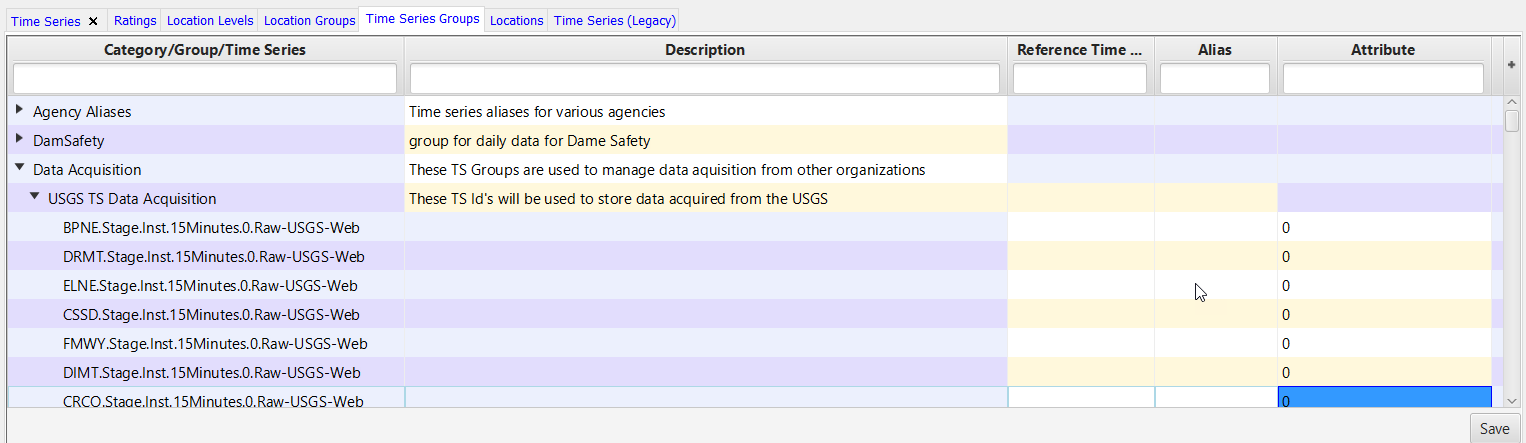


The code below is grabbing all of the time series ids within the group. It will return datatype with 2 selectors. 
 - .df: will provide a the request in a pandas dataframe
 - .json: will provide the request in dictionary format from the decoded json.content

In this code we will be working with panadas dataframes.

In [50]:
#import wincertstore
df = cwms.get_timeseries_group(group_id="USGS TS Data Acquisition",category_id="Data Acquisition",office_id="CWMS").df

In [51]:
# parse out the time seried id into components
df[['location-id','param','type','int','dur','ver']] = df['timeseries-id'].str.split('.', expand=True)

In [52]:
df['base-loc'] = df['location-id'].str.split('-',expand=True)[0]
if 'alias-id' not in df.columns: df['alias-id'] = np.nan
if 'attribute' not in df.columns: df['attribute'] = np.nan
df = df.rename(columns = {'alias-id': 'USGS_Method_TS'})

In [53]:
#grab subset from a specific office
df = df[df['office-id']=='MVP']

# grab a specific location

#df = df[df['location-id']=='TMMT']

# grab a subset of timeseries

#timeseries = ['BowlingGreenIN.Stage.Inst.15Minutes.0.USGS-raw',
#              'BowlingGreenIN.Flow.Inst.15Minutes.0.USGS-raw']
#df = df[df['timeseries-id'].isin(timeseries)]
df

,office-id,timeseries-id,ts-code,USGS_Method_TS,attribute,location-id,param,type,int,dur,ver,base-loc
54,MVP,Cooperstown.Stage.Inst.~15Minutes.0.Raw-USGS,32929016,NaN,0.0,Cooperstown,Stage,Inst,~15Minutes,0,Raw-USGS,Cooperstown
55,MVP,Orwell_Dam-Tailwater.Stage.Inst.~15Minutes.0.R...,35139016,NaN,0.0,Orwell_Dam-Tailwater,Stage,Inst,~15Minutes,0,Raw-USGS,Orwell_Dam
863,MVP,RainbowLake.Elev.Inst.~15Minutes.0.Raw-USGS,77273016,NaN,NaN,RainbowLake,Elev,Inst,~15Minutes,0,Raw-USGS,RainbowLake
864,MVP,RainbowLake.Flow.Inst.~15Minutes.0.Raw-USGS,33033016,NaN,NaN,RainbowLake,Flow,Inst,~15Minutes,0,Raw-USGS,RainbowLake
865,MVP,RainbowLake.Stage.Inst.~15Minutes.0.Raw-USGS,33034016,NaN,NaN,RainbowLake,Stage,Inst,~15Minutes,0,Raw-USGS,RainbowLake
...,...,...,...,...,...,...,...,...,...,...,...,...
1396,MVP,MerrillPrairie.Flow.Inst.~15Minutes.0.Raw-USGS,33045016,NaN,NaN,MerrillPrairie,Flow,Inst,~15Minutes,0,Raw-USGS,MerrillPrairie
1397,MVP,MerrillPrairie.Stage.Inst.~15Minutes.0.Raw-USGS,33046016,NaN,NaN,MerrillPrairie,Stage,Inst,~15Minutes,0,Raw-USGS,MerrillPrairie
1398,MVP,FoxholmDesLacs.Flow.Inst.~15Minutes.0.Raw-USGS,32959016,NaN,NaN,FoxholmDesLacs,Flow,Inst,~15Minutes,0,Raw-USGS,FoxholmDesLacs
1399,MVP,FoxholmDesLacs.Stage.Inst.~15Minutes.0.Raw-USGS,32960016,NaN,NaN,FoxholmDesLacs,Stage,Inst,~15Minutes,0,Raw-USGS,FoxholmDesLacs


The second requirement to use the getUSGS script is to have Aliases set with the USGS station number.  This is set in the Location Groups under Agency Aliases -> USGS Station Number.  The code below grabs all of the locations in that location group.  Again output can be as a dataframe, dictionary, or response object. 

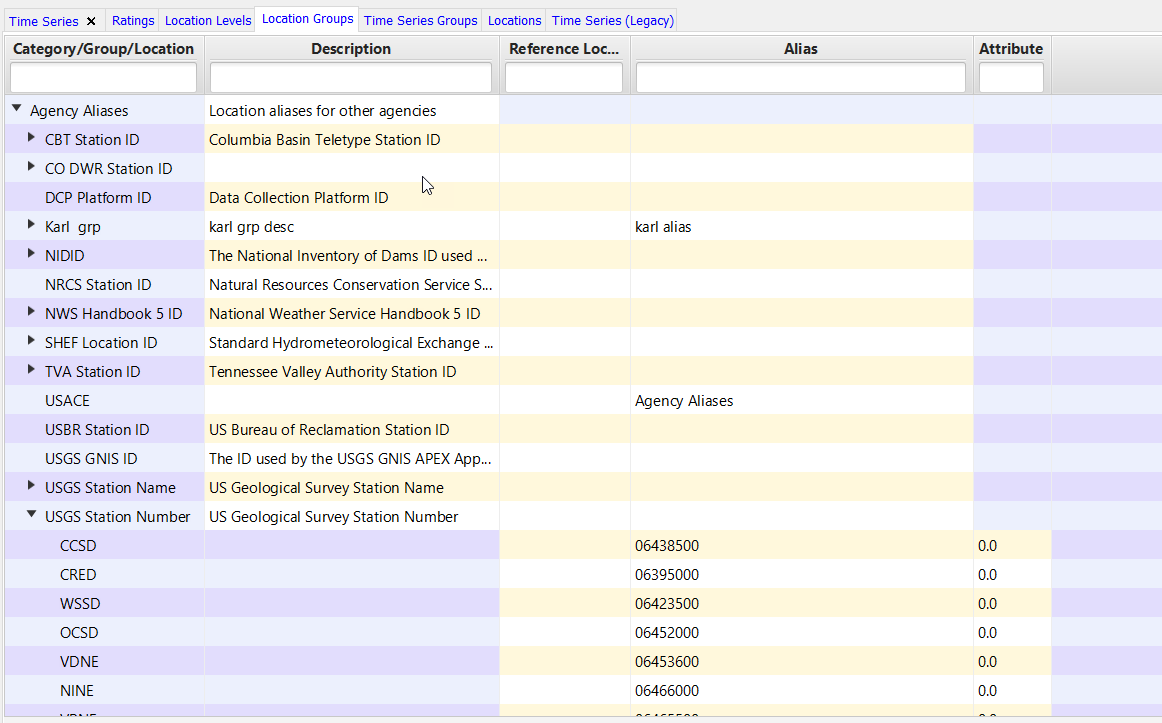

In [54]:
Locdf = cwms.get_location_group(loc_group_id="USGS Station Number",category_id="Agency Aliases",office_id="CWMS").df.set_index('location-id')

In [55]:
Locdf = Locdf[Locdf['office-id']=='MVP']

In [56]:
Locdf

,office-id,alias-id,attribute
location-id,,,
Sparta,MVP,05382325,0.0
LaCrosse,MVP,05383075,0.0
Merrill,MVP,05395000,0.0
MoundsView,MVP,05288580,0.0
PilotMound,MVP,05383950,0.0
...,...,...,...
CNLM5,MVP,05129200,NaN
SCOM5,MVP,NaN,NaN
SpringValley,MVP,NaN,NaN


In [57]:
#Grab all of the locations that have a USGS station number assigned to them
USGS_alias=Locdf[Locdf['alias-id'].notnull()]
#rename the columns
USGS_alias = USGS_alias.rename(columns = {'alias-id': 'USGS_St_Num','attribute':'Loc_attribute'})
#pad the USGS id with 0s if they are not 8 digits long
USGS_alias.USGS_St_Num = USGS_alias.USGS_St_Num.str.rjust(8,'0')

In [58]:
#do an inner join with the time series that are in the USGS time series group and the location group.  Join based on the Location ID and office if
USGS_ts = pd.merge(df, USGS_alias,  how='left', on=['location-id','office-id'])

In [59]:
USGS_ts[USGS_ts.USGS_St_Num.isnull()]

,office-id,timeseries-id,ts-code,USGS_Method_TS,attribute,location-id,param,type,int,dur,ver,base-loc,USGS_St_Num,Loc_attribute
26,MVP,Faribault.Flow.Inst.~15Minutes.0.Raw-USGS,76715016,NaN,NaN,Faribault,Flow,Inst,~15Minutes,0,Raw-USGS,Faribault,NaN,NaN
27,MVP,Faribault.Stage.Inst.~15Minutes.0.Raw-USGS,76714016,NaN,NaN,Faribault,Stage,Inst,~15Minutes,0,Raw-USGS,Faribault,NaN,NaN
372,MVP,Grafton.Flow.Inst.~15Minutes.0.Raw-USGS,50561016,NaN,NaN,Grafton,Flow,Inst,~15Minutes,0,Raw-USGS,Grafton,NaN,NaN
373,MVP,Grafton.Stage.Inst.~15Minutes.0.Raw-USGS,50562016,NaN,NaN,Grafton,Stage,Inst,~15Minutes,0,Raw-USGS,Grafton,NaN,NaN
433,MVP,SpringValley.Flow.Inst.~15Minutes.0.Raw-USGS,34655016,NaN,NaN,SpringValley,Flow,Inst,~15Minutes,0,Raw-USGS,SpringValley,NaN,NaN
434,MVP,SpringValley.Stage.Inst.~15Minutes.0.Raw-USGS,34656016,NaN,NaN,SpringValley,Stage,Inst,~15Minutes,0,Raw-USGS,SpringValley,NaN,NaN


In [60]:
#grab time series with missing USGS_St_Num and check to see if the base location has an assigned USGS station.
if USGS_ts.USGS_St_Num.isnull().any():
    USGS_ts_base = pd.merge(USGS_ts[USGS_ts.USGS_St_Num.isnull()].drop(['USGS_St_Num','Loc_attribute'], axis=1), 
                            USGS_alias, 
                            left_on=['base-loc','office-id'], 
                            right_on=['location-id','office-id'])
    #merge with existing dataframe
    USGS_ts = pd.concat([USGS_ts[USGS_ts['USGS_St_Num'].notnull()], USGS_ts_base], axis=0)
    USGS_ts_base

Create a dataframe that maps CWMS parameters to USGS parameters.  These are the standard maping between parameters.  

In [61]:
columns = ['USGS_PARAMETER','USGS_Alias','CWMS_PARAMETER','CWMS_FACTOR','CWMS_UNIT','CWMS_TYPE']
data = [['00010','Water Temp','Temp-Water',1,'C','Inst'],
['00021','Air Temp','Temp-Air',1,'F','Inst'],
['00035','Wind Speed','Speed-Wind',1,'mph','Inst'],
['00036','Wind Dir','Dir-Wind',1,'deg','Inst'],
['00045','Precip','Precip-Inc',1,'in','Total'],
['00045','Precip','Precip',1,'in','Total'],       
['00052','RelHumidity','%-Humidity',1,'%','Inst'],
['00060','Flow','Flow',1,'cfs','Inst'],
#['00061','Flow',1,'cfs','Inst'],
['00065','Stage','Stage',1,'ft','Inst'],
['00095','Sp Cond','Cond',1,'umho/cm','Inst'],
['00096','Salinity','Conc-Salinity',0.001,'mg/l','Inst'],
#['00062','Elevation','Elev',1,'ft','Inst'],
['72036','Res Storage','Stor',1000,'ac-ft','Inst'],
['62608','Sol Rad','Irrad-Solar',1,'W/m2','Inst'],
#['62614','Elev-Lake','Elev',1,'ft','Inst'],
['63160','Elev-NAVD88','Elev',1,'ft','Inst']]
USGS_Params = pd.DataFrame(data,columns=columns).set_index('CWMS_PARAMETER')

In [62]:
USGS_Params

,USGS_PARAMETER,USGS_Alias,CWMS_FACTOR,CWMS_UNIT,CWMS_TYPE
CWMS_PARAMETER,,,,,
Temp-Water,00010,Water Temp,1.000,C,Inst
Temp-Air,00021,Air Temp,1.000,F,Inst
Speed-Wind,00035,Wind Speed,1.000,mph,Inst
Dir-Wind,00036,Wind Dir,1.000,deg,Inst
Precip-Inc,00045,Precip,1.000,in,Total
Precip,00045,Precip,1.000,in,Total
%-Humidity,00052,RelHumidity,1.000,%,Inst
Flow,00060,Flow,1.000,cfs,Inst
Stage,00065,Stage,1.000,ft,Inst


Custum mapping can be applied by using the attribute in the Time series group.  USGS parameter ID entered in the attribute field will override the default values in the USGS_Params dataframe

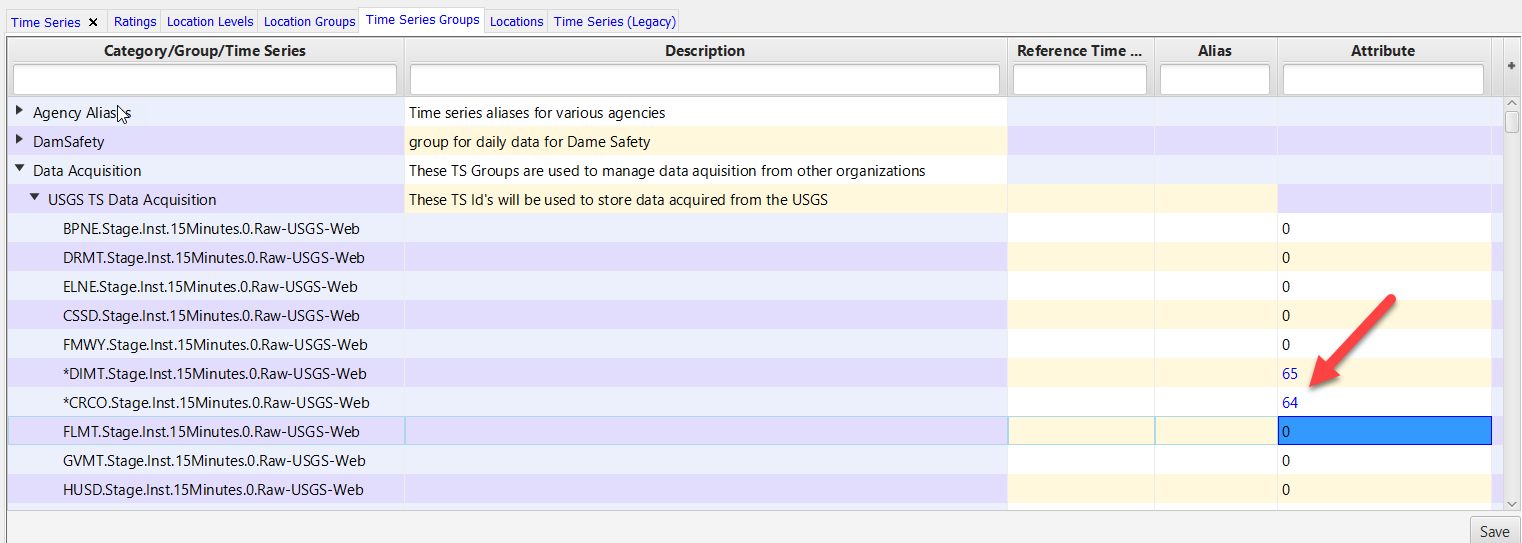

In [63]:
#this code fills in the USGS_Params field with values in the Time Series Group Attribute if it exists.  If it does not exist it
#grabs the default USGS paramter for the coresponding CWMS parameter
USGS_ts.attribute = USGS_ts.apply(lambda x: np.where(x.attribute > 0, str(x.attribute).split('.')[0], USGS_Params.at[x.param, 'USGS_PARAMETER']), axis =1).astype("string")
USGS_ts.attribute = USGS_ts.attribute.str.rjust(5,'0')
#renames the attribute column to USGS_PARAMETER
USGS_ts = USGS_ts.rename(columns = {'attribute': 'USGS_PARAMETER'})

In [64]:
USGS_ts

,office-id,timeseries-id,ts-code,USGS_Method_TS,USGS_PARAMETER,location-id,param,type,int,dur,ver,base-loc,USGS_St_Num,Loc_attribute
0,MVP,Cooperstown.Stage.Inst.~15Minutes.0.Raw-USGS,32929016,NaN,00065,Cooperstown,Stage,Inst,~15Minutes,0,Raw-USGS,Cooperstown,05057000,0.0
1,MVP,Orwell_Dam-Tailwater.Stage.Inst.~15Minutes.0.R...,35139016,NaN,00065,Orwell_Dam-Tailwater,Stage,Inst,~15Minutes,0,Raw-USGS,Orwell_Dam,05046000,0.0
2,MVP,RainbowLake.Elev.Inst.~15Minutes.0.Raw-USGS,77273016,NaN,63160,RainbowLake,Elev,Inst,~15Minutes,0,Raw-USGS,RainbowLake,05391000,0.0
3,MVP,RainbowLake.Flow.Inst.~15Minutes.0.Raw-USGS,33033016,NaN,00060,RainbowLake,Flow,Inst,~15Minutes,0,Raw-USGS,RainbowLake,05391000,0.0
4,MVP,RainbowLake.Stage.Inst.~15Minutes.0.Raw-USGS,33034016,NaN,00065,RainbowLake,Stage,Inst,~15Minutes,0,Raw-USGS,RainbowLake,05391000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,MVP,MerrillPrairie.Flow.Inst.~15Minutes.0.Raw-USGS,33045016,NaN,00060,MerrillPrairie,Flow,Inst,~15Minutes,0,Raw-USGS,MerrillPrairie,05394500,0.0
536,MVP,MerrillPrairie.Stage.Inst.~15Minutes.0.Raw-USGS,33046016,NaN,00065,MerrillPrairie,Stage,Inst,~15Minutes,0,Raw-USGS,MerrillPrairie,05394500,0.0
537,MVP,FoxholmDesLacs.Flow.Inst.~15Minutes.0.Raw-USGS,32959016,NaN,00060,FoxholmDesLacs,Flow,Inst,~15Minutes,0,Raw-USGS,FoxholmDesLacs,05116500,0.0
538,MVP,FoxholmDesLacs.Stage.Inst.~15Minutes.0.Raw-USGS,32960016,NaN,00065,FoxholmDesLacs,Stage,Inst,~15Minutes,0,Raw-USGS,FoxholmDesLacs,05116500,0.0


In [65]:
#grab all of the unique USGS stations numbers to be sent to USGS api
sites = USGS_ts[USGS_ts['USGS_Method_TS'].isna()].USGS_St_Num.unique()

In [66]:
method_sites = USGS_ts[USGS_ts['USGS_Method_TS'].notna()].USGS_St_Num.unique()

In [69]:
def getUSGS_ts(sites, startDT, endDT, access = None):
    '''
    Function to grab data from the USGS based off of dataretieve-python
    '''
    
    import requests
    # Get USGS data
    base_url = "https://waterservices.usgs.gov/nwis/iv/?"

    query_dict = {
        "format": "json",
        "sites": ",".join(sites),
        "startDT" : startDT.isoformat(),
        "endDT" : endDT.isoformat(),
        "access" : access,
        # "parameterCd": ",".join(unique_param_codes),
        #'period': 'P1D',
        #"modifiedSince": "PT6H",
        "siteStatus": "active",
    }

    r = requests.get(base_url, params = query_dict).json()

    #format the responce from USGS API into dataframe
    USGS_data = pd.DataFrame(r["value"]["timeSeries"])
    USGS_data['Id.param'] = USGS_data.name.str.split(':').str[1] + '.' + USGS_data.name.str.split(':').str[2]
    USGS_data=USGS_data.set_index('Id.param')

    return USGS_data

In [71]:
# grab the last 4 hours of data
endDT = datetime.now()
startDT = endDT-timedelta(hours=4)

# get data for all sites from USGS api
USGS_data = pd.DataFrame()
USGS_data_method = pd.DataFrame()

if len(sites) > 0:
    USGS_data = getUSGS_ts(sites, startDT, endDT)
if len(method_sites) > 0:
    USGS_data_method = getUSGS_ts(method_sites, startDT, endDT, 3)


In [ ]:
# lists to hold time series that fail
#noData -> usgs location and parameter were present in USGS api but the values were empty
#NotinAPI -> usgs location and parameter were not retrieved from USGS api
#storErr -> an error occured when saving data to CWMS database
noData = []
NotinAPI = []
storErr = []

# loop through all rows in the USGS_ts dataframe
for index, row in USGS_ts.iterrows():
    #grab the CWMS time series if and the USGS station numbuer plus USGS parameter code
    ts_id = row['timeseries-id']
    USGS_Id_param = f'{row.USGS_St_Num}.{row.USGS_PARAMETER}'
    # check if the USGS st number and para code are in the data obtain from USGS api
    values = pd.DataFrame()
    if (USGS_Id_param in USGS_data.index) or (USGS_Id_param in USGS_data_method.index):
        #grab the time series values obtained from USGS API.
        if pd.isna(row.USGS_Method_TS):
            USGS_data_row = USGS_data.loc[USGS_Id_param]
        else:
            USGS_data_row = USGS_data_method.loc[USGS_Id_param]
        values_df = pd.DataFrame(USGS_data_row['values'])
        #print(values)
        if values_df.shape[0]>1:
            if pd.isna(row.USGS_Method_TS):
                print(f'there are multiple time series for {USGS_Id_param} need to specify the USGS method ts_id for {ts_id}')
            else:
                temp = values_df.method.apply(pd.Series)
                temp = values_df.join(pd.json_normalize(temp.pop(0)))
                print(temp.query(f'methodID == {row.USGS_Method_TS}')['value'].item())
                values = pd.DataFrame(temp.query(f'methodID == {row.USGS_Method_TS}')['value'].item())
        else:
            values = pd.DataFrame(values_df.loc[0, 'value'])
        # if values array is empty then append infor to noData list
        if values.empty:
            noData.append([ts_id,USGS_Id_param])
        else:
            #grab value  and for no data (ie -999999) remove from dataset 
            nodata_val = USGS_data_row['variable']['noDataValue']
            values = values[values.value != str(int(nodata_val))]
            #check again if values dataframe is empty after removing nodata_vals
            if values.empty:
                noData.append([ts_id,USGS_Id_param])
            #if values are present grab information needed to save to CWMS database using CDA
            else:
                values = values.reindex(columns=['dateTime','value','qualifiers'])
                #adjust column names to fit cwms-python format.
                values = values.rename(columns={'dateTime': 'date-time', 'qualifiers': 'quality-code'})
                print(ts_id)           
                units = USGS_data_row['variable']['unit']['unitCode']
                office = row['office-id']
                values['quality-code'] = 0
                
                print(values)
                #write values to CWMS database
                data = cwms.timeseries_df_to_json(data=values,ts_id=ts_id, units=units, office_id=office)
                print(data)
                #x = cwms.store_timeseries(data)
    else: 
        print(f'{USGS_Id_param} for {ts_id} was not found from USGS API')
        NotinAPI.append([ts_id,USGS_Id_param])